In [1]:
# KNN with season

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


def create_error_rate_data(initial_df, test_start_date, percent_gaps):
    df_orig = initial_df.copy()
    df_test = initial_df.copy()
    df_test_drop = initial_df.copy()
    df_test_drop = df_test_drop[df_test_drop.index >= test_start_date]

    len_deleted = int(len(df_test_drop.dropna()) * (percent_gaps / 100))
    start_index_delete_random = np.random.randint(0, len(df_test_drop.dropna()) - len_deleted)
    long_random_drop_indexes_list = list(range(start_index_delete_random, start_index_delete_random + len_deleted))

    date = df_test_drop.dropna().index[long_random_drop_indexes_list]
    drop_indexes = df_test_drop.index[df_test_drop.index.isin(date)].tolist()

    df_for_intervals = df_orig.loc[drop_indexes]

    load_intervals = create_intervals(df_for_intervals)

    df_test['P_l_interval'] = df_test['P_l'].apply(lambda x: find_interval(x, load_intervals))
    df_orig['P_l_interval'] = df_orig['P_l'].apply(lambda x: find_interval(x, load_intervals))

    df_test['is_droped'] = False
    df_test.loc[df_test.index.isin(date), 'P_l'] = np.nan
    df_test.loc[df_test.index.isin(date), 'is_droped'] = True

    return df_orig, df_test, drop_indexes


# def add_additional_features(df):
#     df.loc[:, 'year'] = df.index.year
#     df.loc[:, 'week'] = df.index.isocalendar().week
#     df.loc[:, 'day_of_week'] = df.index.dayofweek
#     df.loc[:, 'hour'] = df.index.hour
#     df.loc[:, 'minute'] = df.index.minute
#     df.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
#     df.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
#     df.loc[:, 'day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
#     df.loc[:, 'day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
#     df.loc[:, 'week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
#     df.loc[:, 'week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
#     it_holidays = holidays.Italy(years=df['year'].unique())
#     df.loc[:, 'is_holiday'] = pd.Series(df.index.date).isin(it_holidays).astype(int).values
#     return df

# def fill_gaps_with_knn(df, n_neighbors=5):
#     features = df[['year', 'week', 'day_of_week', 'hour', 'minute',
#                    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
#                    'week_sin', 'week_cos', 'is_holiday', 'P_l']]
#     # Создание копии DataFrame для изменений
#     filled_df = df.copy()

#     # Индексы с пропущенными значениями в колонке 'P_l'
#     missing_indices = filled_df[filled_df['P_l'].isnull()].index

#     # Отбор признаков и их масштабирование
#     features = filled_df.copy()
#     features = features.drop(columns=['P_l_interval',  'is_droped'])
#     print(features)
#     scaler = MinMaxScaler()
#     features_scaled = scaler.fit_transform(features)

#     # Использование KNN для заполнения пропущенных значений
#     imputer = KNNImputer(n_neighbors=n_neighbors)
#     features_filled = imputer.fit_transform(features_scaled)
#     df_all_fiiled = pd.DataFrame(scaler.inverse_transform(features_filled), columns=features.columns, index=df.index)
#     # Обновление DataFrame только для пропущенных значений в колонке 'P_l'
#     filled_df.loc[missing_indices, 'P_l'] = df_all_fiiled.loc[missing_indices, 'P_l']

#     return filled_df

def calculate_mape_improved(df_orig, df_predict):
    original_series = df_orig.loc[drop_indexes, 'P_l']
    predicted_series = df_predict.loc[drop_indexes, 'P_l']

    original_series = original_series.astype(float)
    predicted_series = predicted_series.astype(float)

    general_mape = np.mean(np.abs((original_series - predicted_series) / original_series)) * 100
    df_predicted_with_error = df_predict.copy()
    mape_values = []
    for index in drop_indexes:
        original_value = df_orig.loc[index, 'P_l']
        predicted_value = df_predict.loc[index, 'P_l']

        mape = np.abs((original_value - predicted_value) / original_value) * 100
        mape_values.append(mape)

    df_predicted_with_error.loc[drop_indexes, 'MAPE'] = mape_values

    mape_by_interval = {}
    for curr_interval in df_predicted_with_error['P_l_interval'].unique():
        df_curr_interval = df_predicted_with_error[df_predicted_with_error['P_l_interval'] == curr_interval]
        df_curr_interval = df_curr_interval[df_curr_interval['is_droped']==True]
        mape = np.mean(df_curr_interval['MAPE'])
        mape_by_interval[curr_interval] = mape

    mape_by_interval = sorted(mape_by_interval.items(), key=lambda x: x[0])
    mape_by_interval = [item for item in mape_by_interval if not np.isnan(item[0]) and not np.isnan(item[1])]
    mape_by_interval = sorted(mape_by_interval, key=lambda x: x[0])
    return df_predicted_with_error, general_mape, mape_by_interval


def calculate_metrics_per_interval(df_orig, df_filled, metric_name):
    df_orig = df_orig.loc[drop_indexes]  # Remove the comma here
    df_filled = df_filled.loc[drop_indexes]
    metrics_by_interval = {}
    for interval in sorted(df_filled['P_l_interval'].unique()):
        orig_values = df_orig[df_orig['P_l_interval'] == interval]['P_l']
        filled_values = df_filled[df_filled['P_l_interval'] == interval]['P_l']
        if metric_name == 'MAPE':
            metric_value = np.mean(np.abs((orig_values - filled_values) / orig_values)) * 100
        elif metric_name == 'RMSE':
            metric_value = np.sqrt(mean_squared_error(orig_values, filled_values))
        elif metric_name == 'R2':
            metric_value = r2_score(orig_values, filled_values)
        elif metric_name == 'MAE':
            metric_value = mean_absolute_error(orig_values, filled_values)
        metrics_by_interval[interval] = metric_value
    return metrics_by_interval

def calculate_and_plot_metrics(df_orig, df_filled, intervals):
    metrics = ['MAPE', 'RMSE', 'R2', 'MAE']
    results = {}

    for metric in metrics:
        results[metric] = calculate_metrics_per_interval(df_orig, df_filled, metric)

    return results


def find_interval(value, load_intervals):
    for i in range(len(load_intervals)-1):
        low_interval = load_intervals[i]
        hight_interval = load_intervals[i+1]
        if value >= low_interval and value < hight_interval:
            interval_num = int(load_intervals.index(low_interval))
            return interval_num


def create_intervals(df, column='P_l', upper_percentile=99, lower_percentile=1, num_classes=10):
    # Определяем верхнюю границу, используя заданный процентиль
    upper_limit = np.percentile(df[column], upper_percentile)
    
    # Определяем нижнюю границу, используя заданный процентиль
    lower_limit = np.percentile(df[column], lower_percentile)
    
    # Генерируем равномерные интервалы между нижним и верхним пределами
    load_intervals = np.linspace(lower_limit, upper_limit, num_classes + 1)
    load_intervals = load_intervals.tolist()
    
    return load_intervals


def calculate_r_squared(y_true, y_pred):
    SS_res = sum((y_true - y_pred) ** 2)
    SS_tot = sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (SS_res / SS_tot)
    return r_squared

def add_additional_features(df):
    df['year'] = df.index.year
    df['week'] = df.index.isocalendar().week
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    # Получаем список праздников
    it_holidays = holidays.Italy(years=df['year'].unique().tolist())
    # Создаем список дат праздников в формате datetime.date
    holiday_dates = [date for date in it_holidays.keys()]

    # Проверяем на принадлежность к праздникам, используя преобразованный список дат
    df['is_holiday'] = df.index.normalize().isin(holiday_dates).astype(int)
    
    return df

def fill_gaps_with_knn(df, n_neighbors=3):
    # Добавление дополнительных признаков сезонности
    df_with_features = add_additional_features(df)
    
    # Создание копии DataFrame для изменений
    filled_df = df_with_features.copy()

    # Индексы с пропущенными значениями в колонке 'P_l'
    missing_indices = filled_df[filled_df['P_l'].isnull()].index

    # Отбор признаков для KNN импутации, включая 'P_l' для вычисления индекса
    features_to_impute = filled_df.drop(columns=['P_l_interval', 'is_droped']) if 'P_l_interval' in filled_df and 'is_droped' in filled_df else filled_df
    
    # Использование KNN для заполнения пропущенных значений
    imputer = KNNImputer(n_neighbors=n_neighbors)
    features_filled = imputer.fit_transform(features_to_impute)

    # Создание DataFrame на основе заполненных данных, включая 'P_l'
    filled_data_df = pd.DataFrame(features_filled, columns=features_to_impute.columns, index=features_to_impute.index)
    
    # Обновление только пропущенных значений в 'P_l'
    filled_df.loc[missing_indices, 'P_l'] = filled_data_df.loc[missing_indices, 'P_l']

    return filled_df


In [2]:
# Read data
df_with_season = pd.read_csv('filled_P_l.csv', parse_dates=['time'], index_col='time')

In [3]:
from datetime import datetime
import time


str_date = '2022-09-07'
gaps_percent = 10

date_timestamp = pd.Timestamp(f'{str_date} 00:00:00+0000', tz='UTC')
df_with_season = df_with_season.dropna()
df_all_values = df_with_season.copy()

df_orig, df_test_with_gaps, drop_indexes = create_error_rate_data(df_all_values, date_timestamp, gaps_percent)

In [4]:
# Marking for 10 intervals from Pmin to Pmax
# Pmin and Pmax are taken from the test interval starting from str_date and long in gaps_percent %

df_only_gaps = df_orig.loc[drop_indexes]
load_intervals = create_intervals(df_only_gaps)
# Нумеровка интервалов исходя из того что интервалы были обозначены
#в расках тестовой вырезки
#df_only_gaps['P_l_interval'] = df_only_gaps['P_l'].apply(lambda x: find_interval(x, load_intervals))


In [5]:
# Filling gaps using KNN
filled_df = fill_gaps_with_knn(df_test_with_gaps)

In [9]:
filled_df[filled_df["is_droped"]==True]

,P_l,P_l_interval,is_droped,year,week,day_of_week,hour,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,week_sin,week_cos,is_holiday
time,,,,,,,,,,,,,,,
2023-06-07 16:50:00+00:00,27484.630000,7.0,True,2023,23,2,16,50,-0.866025,-0.500000,0.974928,-0.222521,0.354605,-0.935016,0
2023-06-07 16:55:00+00:00,27619.193333,8.0,True,2023,23,2,16,55,-0.866025,-0.500000,0.974928,-0.222521,0.354605,-0.935016,0
2023-06-07 17:00:00+00:00,27558.826667,8.0,True,2023,23,2,17,0,-0.965926,-0.258819,0.974928,-0.222521,0.354605,-0.935016,0
2023-06-07 17:05:00+00:00,27630.776667,8.0,True,2023,23,2,17,5,-0.965926,-0.258819,0.974928,-0.222521,0.354605,-0.935016,0
2023-06-07 17:10:00+00:00,27094.643333,8.0,True,2023,23,2,17,10,-0.965926,-0.258819,0.974928,-0.222521,0.354605,-0.935016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-14 14:55:00+00:00,31096.823333,4.0,True,2023,28,4,14,55,-0.500000,-0.866025,-0.433884,-0.900969,-0.239316,-0.970942,0
2023-07-14 15:00:00+00:00,30864.630000,4.0,True,2023,28,4,15,0,-0.707107,-0.707107,-0.433884,-0.900969,-0.239316,-0.970942,0
2023-07-14 15:05:00+00:00,31623.956667,4.0,True,2023,28,4,15,5,-0.707107,-0.707107,-0.433884,-0.900969,-0.239316,-0.970942,0


In [6]:
# MAPE
df_predicted_with_error, general_mape, mape_by_interval = calculate_mape_improved(
    df_orig,
    filled_df
)

[(0.0, 22.843477865556377), (1.0, 15.231986262563698), (2.0, 11.212413996097268), (3.0, 12.41431810122922), (4.0, 10.277123150374567), (5.0, 7.218876686373381), (6.0, 7.788274101215511), (7.0, 9.443942725275656), (8.0, 13.672450892333359), (9.0, 14.285361875146437)]
[(15971.84673, 18482.162057), (18482.162057, 20992.477384), (20992.477384, 23502.792711000002), (23502.792711000002, 26013.108038000006), (26013.108038000006, 28523.423365000002), (28523.423365000002, 31033.738692000006), (31033.738692000006, 33544.05401900001), (33544.05401900001, 36054.36934600001), (36054.36934600001, 38564.68467300001), (38564.68467300001, 41075.00000000001)]


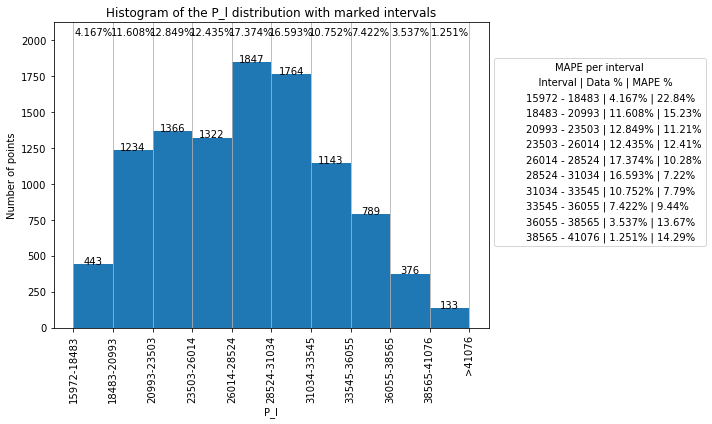

In [7]:
# Histogram of data distribution in df_only_gaps by intervals
import matplotlib.pyplot as plt
import numpy as np
import math as m

def create_intervals_droped(load_intervals):
    intervals = []
    for i in range(len(load_intervals) - 1):
        low_interval = load_intervals[i]
        high_interval = load_intervals[i + 1]
        intervals.append((low_interval, high_interval))
    return intervals

intervals = create_intervals_droped(load_intervals)
print(mape_by_interval)
new_mape_by_interval = []
print(intervals)
for i in range(len(intervals)):
    new_mape_by_interval.append((intervals[i], mape_by_interval[i][1]))

mape_by_interval = new_mape_by_interval

data = df_only_gaps['P_l']

plt.figure(figsize=(10, 6))

n, bins, patches = plt.hist(data, bins=[interval[0] for interval in intervals] + [intervals[-1][1]])

plt.xlabel('P_l')
plt.ylabel('Number of points')
plt.title('Histogram of the P_l distribution with marked intervals')

plt.xticks([interval[0] for interval in intervals] + [intervals[-1][1]],
           [f'{m.ceil(interval[0])}-{m.ceil(interval[1])}' for interval in intervals] + [f'>{m.ceil(intervals[-1][1])}'],
           rotation=90)

plt.grid(axis='x')

total_samples = len(data)
for i, interval in enumerate(intervals):
    count_in_interval = ((data >= interval[0]) & (data <= interval[1])).sum()
    percentage = count_in_interval / total_samples
    width = bins[i + 1] - bins[i]
    plt.text(bins[i] + width / 2, np.max(n) * 1.1, f'{round(percentage * 100, 3)}%', ha='center')  # Уменьшение координаты y для текста процентов
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, count_in_interval, f'{count_in_interval}', ha='center')

plt.plot([], [], label='    Interval | Data % | MAPE %', color='white')

for interval, value in mape_by_interval:
    count_in_interval = ((data >= interval[0]) & (data <= interval[1])).sum()
    percentage = count_in_interval / total_samples
    label = f'{m.ceil(interval[0])} - {m.ceil(interval[1])} | {round(percentage*100, 3)}% | {round(value, 2)}%'
    plt.plot([], [], label=label, color='white')

plt.legend(title='MAPE per interval', facecolor='white', bbox_to_anchor=(1, 0.9))

plt.ylim(0, np.max(n) * 1.15)

plt.tight_layout()

plt.savefig('histogram.png')

plt.show()

In [8]:
df_only_filled = filled_df.loc[drop_indexes]
df_orig_cut = df_orig.loc[drop_indexes]

for interval in range(0, 10):
    orig_values = df_orig_cut[df_orig_cut['P_l_interval'] == interval]['P_l']
    filled_values = df_only_filled[df_only_filled['P_l_interval'] == interval]['P_l']
    rmse = np.sqrt(mean_squared_error(orig_values, filled_values))
    r2 = r2_score(orig_values, filled_values)
    mae = mean_absolute_error(orig_values, filled_values)
    mape_by_interval[interval] = list(mape_by_interval[interval])
    mape_by_interval[interval].append(rmse)
    mape_by_interval[interval].append(r2)
    mape_by_interval[interval].append(mae)

start_interval = []
end_interval = []
mape = []
rmse = []
r2 = []
mae = []

for i in range(len(mape_by_interval)):
    start_interval.append(mape_by_interval[i][0][0])
    end_interval.append(mape_by_interval[i][0][1])
    mape.append(mape_by_interval[i][1])
    rmse.append(mape_by_interval[i][2])
    r2.append(mape_by_interval[i][3])
    mae.append(mape_by_interval[i][4])

df_error = pd.DataFrame(columns=['Start Interval', 'End Interval', 'MAPE', 'RMSE', 'R2', 'MAE'])

df_error['Start Interval'], df_error['End Interval'], df_error['MAPE'], df_error['RMSE'], df_error['R2'], df_error['MAE'] = start_interval, end_interval, mape, rmse, r2, mae

df_error.to_csv(f'error_{gaps_percent}_gaps.csv')

df_error

,Start Interval,End Interval,MAPE,RMSE,R2,MAE
0,15971.846730,18482.162057,22.843478,4286.267118,-31.035995,3983.291287
1,18482.162057,20992.477384,15.231986,3518.661238,-22.321458,3010.463064
2,20992.477384,23502.792711,11.212414,3128.309901,-17.326929,2489.490479
3,23502.792711,26013.108038,12.414318,3797.270999,-27.061105,3074.056563
4,26013.108038,28523.423365,10.277123,3477.537458,-22.288451,2802.823836
5,28523.423365,31033.738692,7.218877,2865.650610,-14.770521,2141.143835
6,31033.738692,33544.054019,7.788274,3255.838628,-20.089862,2511.453814
7,33544.054019,36054.369346,9.443943,4162.023007,-31.968655,3282.028159
8,36054.369346,38564.684673,13.672451,6063.613850,-83.261055,5069.419079
9,38564.684673,41075.000000,14.285362,6621.507527,-89.677215,5670.281116


In [ ]:
# Сохранение df_filled в файл CSV
filled_df.to_csv('/Users/dmitrii/Desktop/PhD/Python/PhD_code_project/Machine-Learning-Techniques-for-Ensuring-the-Health-of-Citizens/notebooks/results/filled_with_SKNN.csv', index=True)
